# Notebook 1:<br> **Dataset Exploration and Preprocessing**

## Problem Framing and Dataset Discovery

### 1. Problem Definition

As defined in the `Problem Definition` document:<br>

Predict whether a student in a given course will fall into Low / Medium / High risk of course outcome by end of course, using data recorded up to Week 12 (Day 96), so that course staff can prioritize early supportive interventions for learners most likely to need help.

Classification:<br>

1. **Low** risk for *Pass* or *Distinction*
2. **Medium** risk for *Fail*  
3. **High** risk for *Withdrawn*

For more details, please reference `/reports/01_problem_definition.md` in this repository and the `README.md` documents.

### 2. Setup

Initial setup for the notebook:

In [1]:
# Install requirements into the current kernel
import sys
import subprocess
print("Installing requirements from requirements.txt (this may take a minute)...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "../requirements.txt"])
print("Done. If imports still fail, restart the kernel (Kernel -> Restart).")

Installing requirements from requirements.txt (this may take a minute)...
Done. If imports still fail, restart the kernel (Kernel -> Restart).


Imports and display options: 

In [2]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import joblib

# scikit-learn imports
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42   # For reproducibility
CUTOFF_DAY = 98     # this is the cutoff day set to 14 weeks of the course (Day 98)

# Directories (relative to notebook location in notebooks)
RAW_DIR = Path("../inputs/raw")    # raw data directory
OUT_DIR = Path("../outputs")       # output directory  
FIG_DIR = OUT_DIR / "figures"       # figure output directory
TAB_DIR = OUT_DIR / "tables"        # table output directory
DATA_DIR = OUT_DIR / "data"         # processed data output directory

# Ensure output directories exist
for d in [OUT_DIR, FIG_DIR, TAB_DIR, DATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Set pandas display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

### 3. Identify Dataset and Integrity

Verify the raw dataset's completeness and integrity before processing:

1. Ensure all required CSV files are present in the `raw` directory.
2. Compute MD5 checksums to detect data corruption or unauthorized changes.
3. Save a file inventory with sizes and hashes to `raw_file_inventory_md5.csv` for version control and reproducibility.

In [3]:
# Verify expected raw files exist
EXPECTED_FILES = [
    "courses.csv",
    "assessments.csv",
    "vle.csv",
    "studentInfo.csv",
    "studentRegistration.csv",
    "studentAssessment.csv",
    "studentVle.csv",
]

# Function to compute MD5 checksum of a file
def md5_file(path: Path, chunk_size: int = 2**20) -> str:
    h = hashlib.md5()
    with path.open("rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

missing = [f for f in EXPECTED_FILES if not (RAW_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        f"Missing expected CSV(s) in {RAW_DIR}:\n- " + "\n- ".join(missing)
    )

# Create inventory of raw files with sizes and MD5 checksums (in /tables/)
inventory = []
for f in EXPECTED_FILES:
    p = RAW_DIR / f
    inventory.append({
        "file": f,
        "bytes": p.stat().st_size,
        "md5": md5_file(p)
    })

inv_df = pd.DataFrame(inventory).sort_values("file")
inv_df.to_csv(TAB_DIR / "raw_file_inventory_md5.csv", index=False)
inv_df

,file,bytes,md5
1,assessments.csv,8200,6126f9d435767bcc70134b46f21c2a90
0,courses.csv,526,4c3df8a42a98a0d26b22f507007c31a8
5,studentAssessment.csv,5690310,9ceb38acaeb26fbc15c98b563290c1db
3,studentInfo.csv,3461652,ead11d001fe8b7aed1469daa643a812c
4,studentRegistration.csv,1109984,ef06e3d5784dc7dffe06ef911c5b190c
6,studentVle.csv,453836331,b8aae6f4ffd1523319aeb56d66b17f72
2,vle.csv,260126,0e7ef38c483daca42900ca426b66f8da


### 4. Dataset Contents and Tables

Reviewing the different tables used:

In [4]:
# Define the different tables used and create a dataframe for each
courses = pd.read_csv(RAW_DIR / "courses.csv")
assessments = pd.read_csv(RAW_DIR / "assessments.csv")
vle = pd.read_csv(RAW_DIR / "vle.csv")
studentInfo = pd.read_csv(RAW_DIR / "studentInfo.csv")
studentReg = pd.read_csv(RAW_DIR / "studentRegistration.csv")
studentAssess = pd.read_csv(RAW_DIR / "studentAssessment.csv")
studentVle = pd.read_csv(RAW_DIR / "studentVle.csv")

# Print the shape of each table
print("Shapes of loaded data tables:")
print("courses:", courses.shape)
print("assessments:", assessments.shape)
print("vle:", vle.shape)
print("studentInfo:", studentInfo.shape)
print("studentRegistration:", studentReg.shape)
print("studentAssessment:", studentAssess.shape)
print("studentVle:", studentVle.shape)

Shapes of loaded data tables:
courses: (22, 3)
assessments: (206, 6)
vle: (6364, 6)
studentInfo: (32593, 12)
studentRegistration: (32593, 5)
studentAssessment: (173912, 5)
studentVle: (10655280, 6)


Review the structure of critical tables (the features):

In [5]:
print("\nSample data from the Courses table:")
courses.head()


Sample data from the Courses table:


,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [6]:
print("\nSample data from the Student Information table:")
studentInfo.head()


Sample data from the Student Information table:


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [7]:
print("\nSample data from the VLE table:")
vle.head()


Sample data from the VLE table:


,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### 5. Data Dictionary

Supplementing the main file of the DATA_DICTIONARY.md by creating a data dictionary snapshot based on the structure of all loaded DataFrames:

In [8]:
# Capture metadata and sample values for a specific DataFrame
def data_dictionary_snapshot(df: pd.DataFrame, name: str, n_examples: int = 3) -> pd.DataFrame:
    rows = []
    for c in df.columns:
        examples = df[c].dropna().astype(str).head(n_examples).tolist()
        rows.append({
            "table": name,
            "column": c,
            "dtype": str(df[c].dtype),
            "missing_pct": float(df[c].isna().mean() * 100), # percentage of missing values
            "examples": " | ".join(examples)
        })
    return pd.DataFrame(rows)

# Combine snapshots of all tables into a single master dictionary
dd = pd.concat([
    data_dictionary_snapshot(courses, "courses"),
    data_dictionary_snapshot(assessments, "assessments"),
    data_dictionary_snapshot(vle, "vle"),
    data_dictionary_snapshot(studentInfo, "studentInfo"),
    data_dictionary_snapshot(studentReg, "studentRegistration"),
    data_dictionary_snapshot(studentAssess, "studentAssessment"),
    data_dictionary_snapshot(studentVle, "studentVle"),
], ignore_index=True)

# Export for documentation and display the first 100 (upper limit, there's less rows) rows in the head of the table
dd.to_csv(TAB_DIR / "data_dictionary_snapshot.csv", index=False)
dd.head(100)


,table,column,dtype,missing_pct,examples
0,courses,code_module,object,0.000000,AAA | AAA | BBB
1,courses,code_presentation,object,0.000000,2013J | 2014J | 2013J
2,courses,module_presentation_length,int64,0.000000,268 | 269 | 268
3,assessments,code_module,object,0.000000,AAA | AAA | AAA
4,assessments,code_presentation,object,0.000000,2013J | 2013J | 2013J
5,assessments,id_assessment,int64,0.000000,1752 | 1753 | 1754
6,assessments,assessment_type,object,0.000000,TMA | TMA | TMA
7,assessments,date,float64,5.339806,19.0 | 54.0 | 117.0
8,assessments,weight,float64,0.000000,10.0 | 20.0 | 20.0
9,vle,id_site,int64,0.000000,546943 | 546712 | 546998


## Data Preparation

### 6. Timeline

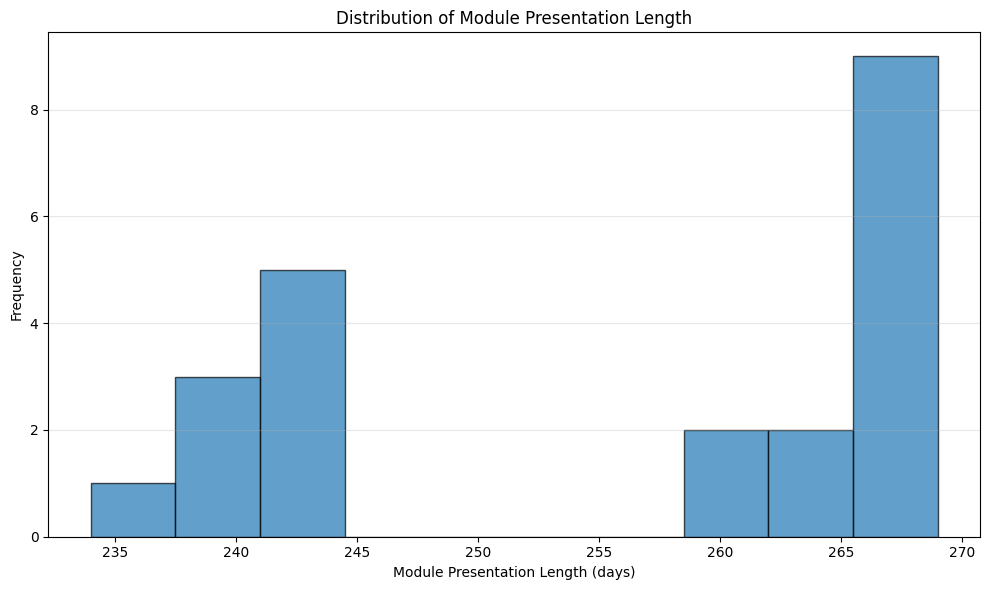

In [9]:
# Plot histogram of module_presentation_length
plt.figure(figsize=(10, 6))
plt.hist(courses['module_presentation_length'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Module Presentation Length (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Module Presentation Length')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_1_module_presentation_length_histogram.png", dpi=200)
plt.show()

In [10]:
# Alternative: Use pandas describe() for more comprehensive stats
print("\nDetailed statistics:")
print(courses['module_presentation_length'].describe())


Detailed statistics:
count     22.000000
mean     255.545455
std       13.654677
min      234.000000
25%      241.000000
50%      261.500000
75%      268.000000
max      269.000000
Name: module_presentation_length, dtype: float64


**Insight:**<br>
The duration of courses is over 200 days, the cutoff needs adjustment (8 weeks might be too short). Update selection of time to about half of the duration of a course (module-presentation combination) from the assumed 8 weeks to 14 weeks since all courses listed are over 234 days.

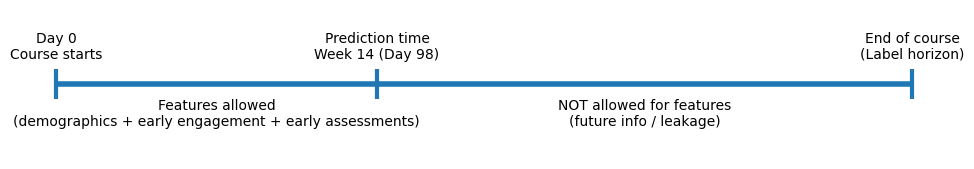

In [11]:
# Visualization: Timeline showing prediction time and feature leakage cutoff
fig, ax = plt.subplots(figsize=(10, 1.8))
ax.hlines(0, 0, courses['module_presentation_length'].median(), linewidth=4)
ax.vlines([0, CUTOFF_DAY, courses['module_presentation_length'].median()], -0.2, 0.2, linewidth=3)

ax.text(0, 0.35, "Day 0\nCourse starts", ha="center")
ax.text(CUTOFF_DAY, 0.35, f"Prediction time\nWeek 14 (Day {CUTOFF_DAY})", ha="center")
ax.text(courses['module_presentation_length'].median(), 0.35, "End of course\n(Label horizon)", ha="center")

ax.text(CUTOFF_DAY/2, -0.55, "Features allowed\n(demographics + early engagement + early assessments)", ha="center")
ax.text((CUTOFF_DAY+courses['module_presentation_length'].median())/2, -0.55, "NOT allowed for features\n(future info / leakage)", ha="center")

ax.set_ylim(-1, 1)
ax.set_xlim(-2, courses['module_presentation_length'].median()+2)
ax.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_2_timeline_prediction_time.png", dpi=200)
plt.show()


**Interpretation:**<br>
This timeline helps determine the cutoff date (as a number of days from the coures start day). All features must be computed using data available up to to the cutoff, while labels reflect end-of-course outcomes. 

Adjustment:<br>
The value of `CUTOFF_DAY` was updated to 98 (days) since all courses are longer than 200 days. This might need to be optimized again in a later stage.

This prevents “peeking into the future,” which would inflate performance and produce a model that cannot be used in a real early-warning setting.


## Defining Class Labels and Related Checks

### 7. Define Labels

Apply the mapping of a Risk (new engineered feature) to the Student Information dataframe based on the value of the `final_result` feature. 

In [12]:
# Create risk tiers based on final_result and add it to the Student Information table
studentInfo["final_result"] = studentInfo["final_result"].astype(str)

# Labels:
# 1. Low risk = Pass or Distinction
# 2. Medium risk = Fail
# 3. High risk = Withdrawn
label_map = {
    "Distinction": "Low Risk",
    "Pass": "Low Risk",
    "Fail": "Medium Risk",
    "Withdrawn": "High Risk",
}

# Map final_result to risk_tier
studentInfo["risk_tier"] = studentInfo["final_result"].map(label_map)
labeled = studentInfo.dropna(subset=["risk_tier"]).copy()

print("Show the rows affected:")
print("Kept rows:", labeled.shape[0], "of", studentInfo.shape[0])
labeled["risk_tier"].value_counts(dropna=False) # display the counts of each risk level


Show the rows affected:
Kept rows: 32593 of 32593


risk_tier
Low Risk       15385
High Risk      10156
Medium Risk     7052
Name: count, dtype: int64

### 8. Check for Imbalance

Visualizing the class labels to identify any imbalance:

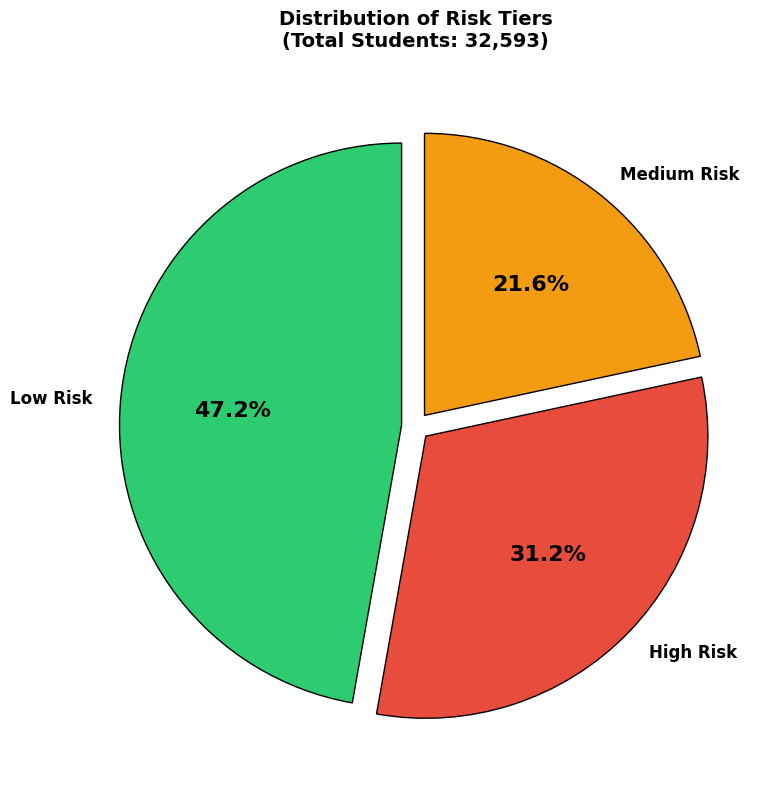


Risk Tier Distribution:
risk_tier
Low Risk       15385
High Risk      10156
Medium Risk     7052
Name: count, dtype: int64

Total labeled students: 32,593


In [13]:
# Create a pie chart for risk_tier distribution
risk_counts = labeled["risk_tier"].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green for Low, Orange for Medium, Red for High
explode = (0.05, 0.05, 0.05)  # Slightly separate all slices

wedges, texts, autotexts = ax.pie(
    risk_counts.values,
    labels=risk_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Enhance text formatting
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

# Add title with total count
ax.set_title(f'Distribution of Risk Tiers\n(Total Students: {labeled.shape[0]:,})', 
             fontsize=14, weight='bold', pad=20)


plt.tight_layout()
plt.savefig(FIG_DIR / "visual_3_risk_tier_distribution.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nRisk Tier Distribution:")
print(risk_counts)
print(f"\nTotal labeled students: {labeled.shape[0]:,}")

**Insight(s):**<br>
1. The chart if the dataset is imbalanced across the three risk tiers. As one class dominates, accuracy becomes unreliable. Because early-warning use cases typically care about correctly identifying High Risk (Withdrawn) and Medium Risk (Fail), the solution will prioritize macro-F1 as the primary evaluation metric for the models.
2. The assumption was the Withdrawn would be the smallest group, this is not the case.


## Handle Leakage

### 9. Check for Timeline Issues (Events that Already Happened)

When considering what might happen before the cutoff date, there are two scenarios that stand out:

1. Students already withdrew from the course (for example, some programs have the option to leave the course withing the first few weeks with no penalty).
2. It is possible that within the cutoff period, a student's performance in assessments is unfixable, so they will fail the course regardless of future success. 

Only the first scenario will be handled since it's unlikely the that assessment structure makes the second scenario possible. 


In [14]:
base = labeled.merge(
    studentReg,
    on=["code_module", "code_presentation", "id_student"],
    how="left",
    validate="1:1"
)

for c in ["date_registration", "date_unregistration"]:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce")

pre_cutoff_withdraw = base["date_unregistration"].notna() & (base["date_unregistration"] <= CUTOFF_DAY)
print("Rows unregistered by prediction time:", int(pre_cutoff_withdraw.sum()))

base = base.loc[~pre_cutoff_withdraw].copy()
print("Base after exclusion:", base.shape)
base.head()


Rows unregistered by prediction time: 7240
Base after exclusion: (25353, 15)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,risk_tier,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,Low Risk,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Low Risk,-53.0,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Low Risk,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Low Risk,-176.0,NaN
5,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Pass,Low Risk,-110.0,NaN


Checking if the removal of the records changes the class distribution in a significant way:

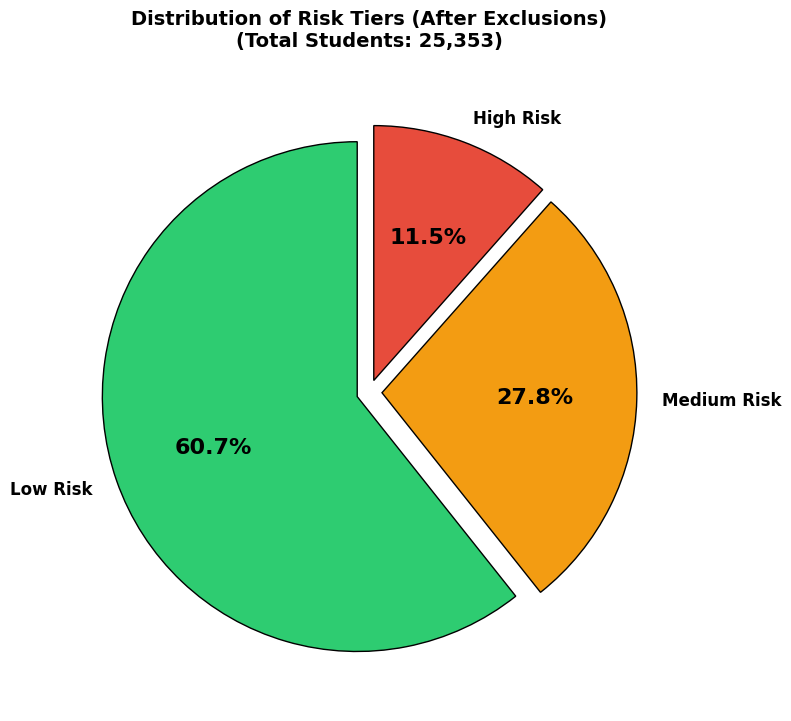


Risk Tier Distribution (After Exclusions):
risk_tier
Low Risk       15385
Medium Risk     7044
High Risk       2924
Name: count, dtype: int64

Total students after exclusion: 25,353
Students excluded (withdrew before cutoff): 7,240


In [15]:
# Create a pie chart for risk_tier distribution in base
risk_counts_base = base["risk_tier"].value_counts()

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green for Low, Orange for Medium, Red for High
explode = (0.05, 0.05, 0.05)  # Slightly separate all slices

wedges, texts, autotexts = ax.pie(
    risk_counts_base.values,
    labels=risk_counts_base.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

# Enhance text formatting
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(16)
    autotext.set_weight('bold')

# Add title with total count
ax.set_title(f'Distribution of Risk Tiers (After Exclusions)\n(Total Students: {base.shape[0]:,})', 
             fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(FIG_DIR / "visual_4_risk_tier_distribution_after_exclusion.png", dpi=200, bbox_inches='tight')
plt.show()

print("\nRisk Tier Distribution (After Exclusions):")
print(risk_counts_base)
print(f"\nTotal students after exclusion: {base.shape[0]:,}")
print(f"Students excluded (withdrew before cutoff): {labeled.shape[0] - base.shape[0]:,}")

### 10. Ensure that Only Pre-Cutoff Assessments are Included

The assessment has to have occurred prior to the cutoff date (within the defined number of days from the course start).

Weighting:
Not all assessments contribute equally to the final course result. The weight field (from `assessments.csv`) represents the relative contribution an assessment counts toward the overall grade. Therefore, weighting turns “a score on an assessment” into “how much that score contributes to the course outcome.”


In [16]:
# Generate assessment features up to the cutoff day
assessments["date"] = pd.to_numeric(assessments["date"], errors="coerce")
assessments["weight"] = pd.to_numeric(assessments["weight"], errors="coerce")
studentAssess["date_submitted"] = pd.to_numeric(studentAssess["date_submitted"], errors="coerce")
studentAssess["score"] = pd.to_numeric(studentAssess["score"], errors="coerce")

# Filter assessments to only those with a date on or before the cutoff day
early_assess = assessments.loc[assessments["date"].notna() & (assessments["date"] <= CUTOFF_DAY)].copy()

# Merge student assessments with early assessments to get relevant info
sa = studentAssess.merge(
    early_assess[["id_assessment", "code_module", "code_presentation", "weight", "date"]],
    on="id_assessment",
    how="inner"
)

# Calculate weighted score for each assessment
sa["weighted_score"] = sa["score"] * (sa["weight"] / 100.0)

# Aggregate assessment features per student up to the cutoff day
assess_feat = (
    sa.groupby(["code_module", "code_presentation", "id_student"], as_index=False)
      .agg(
          assessments_submitted_cutoff=("id_assessment", "count"),
          avg_assessment_score_cutoff=("score", "mean"),
          sum_weighted_score_cutoff=("weighted_score", "sum"),
          latest_submit_day_cutoff=("date_submitted", "max")
      )
)

# Export assessment features summary
assess_feat.to_csv(TAB_DIR / "assessment_features_early_summary.csv", index=False)
assess_feat.head()


,code_module,code_presentation,id_student,assessments_submitted_cutoff,avg_assessment_score_cutoff,sum_weighted_score_cutoff,latest_submit_day_cutoff
0,AAA,2013J,11391,2,81.5,24.8,53
1,AAA,2013J,28400,2,69.0,20.6,52
2,AAA,2013J,31604,2,71.5,21.4,51
3,AAA,2013J,32885,2,49.5,12.9,75
4,AAA,2013J,38053,2,74.0,21.7,64


### 11. Include Engagement with the VLE (Platform)

Turn the data in studentVle.csv log of activities (engagement) into set limited to the cutoff period in terms of engagement without loading the whole file into memory.

Note: The records are processed with a scalable chunking (using 50,000 records at a time) as an optimization given that the dataset is long log file.

In [17]:
# Generate VLE features up to the cutoff day
vle_map = vle[["id_site", "activity_type"]].drop_duplicates()
site_to_type = dict(zip(vle_map["id_site"], vle_map["activity_type"]))

# Columns to read from studentVle
usecols = ["code_module", "code_presentation", "id_student", "id_site", "date", "sum_click"]

# Initialize dictionaries to hold aggregated features
total_clicks = {}
interactions = {}
daily_clicks = {}
type_clicks = {}

# Function to add to dictionary with accumulation
def add_to_dict(d, key, value):
    d[key] = d.get(key, 0) + value

# Process studentVle in chunks
chunksize = 50_000                     # to manage memory usage
sv_path = RAW_DIR / "studentVle.csv"    # path to studentVle.csv

# Read studentVle in chunks to manage memory usage
reader = pd.read_csv(sv_path, usecols=usecols, chunksize=chunksize)

# Process each chunk
for i, chunk in enumerate(reader, start=1):

    # Convert date and sum_click to numeric, coerce errors to NaN
    chunk["date"] = pd.to_numeric(chunk["date"], errors="coerce")
    chunk["sum_click"] = pd.to_numeric(chunk["sum_click"], errors="coerce")

    # Filter to only dates on or before the cutoff day
    chunk = chunk.loc[chunk["date"].notna() & (chunk["date"] <= CUTOFF_DAY)].copy()
    if chunk.empty:
        continue

    # Map id_site to activity_type
    # - Maps each id_site to an activity_type using the dictionary.
    # - Anything unmapped becomes "Unknown".
    chunk["activity_type"] = chunk["id_site"].map(site_to_type).fillna("Unknown")

    # Aggregate features
    g_total = chunk.groupby(["code_module", "code_presentation", "id_student"])["sum_click"].sum()
    for k, v in g_total.items():
        add_to_dict(total_clicks, k, float(v))

    # Count interactions
    g_n = chunk.groupby(["code_module", "code_presentation", "id_student"]).size()
    for k, v in g_n.items():
        add_to_dict(interactions, k, int(v))

    # Aggregate daily clicks
    g_day = chunk.groupby(["code_module", "code_presentation", "id_student", "date"])["sum_click"].sum()
    for k, v in g_day.items():
        add_to_dict(daily_clicks, k, float(v))

    # Aggregate clicks by activity type
    g_type = chunk.groupby(["code_module", "code_presentation", "id_student", "activity_type"])["sum_click"].sum()
    for k, v in g_type.items():
        add_to_dict(type_clicks, k, float(v))

    # Progress update
    if i % 5 == 0:
        print(f"Processed chunks: {i}")

print("\nScanning of records is complete.")
print("\nEnrollments with clicks:", len(total_clicks))


Processed chunks: 5
Processed chunks: 10
Processed chunks: 20
Processed chunks: 25
Processed chunks: 30
Processed chunks: 35
Processed chunks: 40
Processed chunks: 50
Processed chunks: 55
Processed chunks: 65
Processed chunks: 70
Processed chunks: 75
Processed chunks: 80
Processed chunks: 90
Processed chunks: 95
Processed chunks: 100
Processed chunks: 110
Processed chunks: 115
Processed chunks: 120
Processed chunks: 130
Processed chunks: 135
Processed chunks: 145
Processed chunks: 150
Processed chunks: 155
Processed chunks: 170
Processed chunks: 175
Processed chunks: 185
Processed chunks: 190
Processed chunks: 210

Scanning of records is complete.

Enrollments with clicks: 29169


Uses the data that was filtered from studentVle.csv (up to the cutoff day) and turns it into a single feature table with one row per student–enrollment and saves it as a CSV for later modeling.

The resulting table converts high-volume clickstream logs into a one-row-per-unit dataset suitable for classification modeling. It captures:<br>
- Volume (how much activity)
- Consistency (how often activity occurs)
- Stability (how variable activity is over time)
- Type (what kinds of course resources are used in multiple columns)

In [18]:
# Compile VLE features into DataFrames
vle_rows = []

# Populate vle_rows with total clicks and interactions
for (m, p, s), clicks in total_clicks.items():
    vle_rows.append({
        "code_module": m,                                       # module code
        "code_presentation": p,                                 # presentation code
        "id_student": s,                                        # student id
        "total_clicks_cutoff": clicks,                          # total clicks
        "interactions_cutoff": interactions.get((m, p, s), 0),  # add interactions
    })

# Create DataFrame from vle_rows
vle_feat = pd.DataFrame(vle_rows)

# Create DataFrame for daily clicks
day_df = pd.DataFrame(
    [(m, p, s, d, c) for (m, p, s, d), c in daily_clicks.items()],
    columns=["code_module", "code_presentation", "id_student", "date", "daily_clicks"]
)

# Calculate active days and daily click statistics
active_days = (day_df.groupby(["code_module", "code_presentation", "id_student"])
                   .size()
                   .rename("active_days_cutoff")
                   .reset_index())

# Calculate mean and std of daily clicks
day_stats = (day_df.groupby(["code_module", "code_presentation", "id_student"])["daily_clicks"]
                 .agg(daily_clicks_mean_cutoff="mean", daily_clicks_std_cutoff="std")
                 .reset_index())

# Merge active days and day stats into vle_feat
vle_feat = vle_feat.merge(active_days, on=["code_module", "code_presentation", "id_student"], how="left")

# Merge daily click statistics
vle_feat = vle_feat.merge(day_stats, on=["code_module", "code_presentation", "id_student"], how="left")

# Calculate average clicks per active day
vle_feat["avg_clicks_per_active_day_cutoff"] = vle_feat["total_clicks_cutoff"] / vle_feat["active_days_cutoff"].replace(0, np.nan)

# Create DataFrame for clicks by activity type
type_df = pd.DataFrame(
    [(m, p, s, t, c) for (m, p, s, t), c in type_clicks.items()],
    columns=["code_module", "code_presentation", "id_student", "activity_type", "clicks"]
)

# Pivot to wide format
type_wide = (type_df.pivot_table(
    index=["code_module", "code_presentation", "id_student"],
    columns="activity_type",
    values="clicks",
    aggfunc="sum",
    fill_value=0.0
).reset_index())

# Rename columns to indicate cutoff
activity_cols = [c for c in type_wide.columns if c not in ["code_module", "code_presentation", "id_student"]]
type_wide = type_wide.rename(columns={c: f"clicks_cutoff_{c}" for c in activity_cols})

# Merge activity type clicks into vle_feat
vle_feat = vle_feat.merge(type_wide, on=["code_module", "code_presentation", "id_student"], how="left")

# Export VLE features summary
vle_feat.to_csv(TAB_DIR / "vle_features_early_summary.csv", index=False)

# Display the first few rows of vle_feat
vle_feat.head()


,code_module,code_presentation,id_student,total_clicks_cutoff,interactions_cutoff,active_days_cutoff,daily_clicks_mean_cutoff,daily_clicks_std_cutoff,avg_clicks_per_active_day_cutoff,clicks_cutoff_dataplus,clicks_cutoff_dualpane,clicks_cutoff_externalquiz,clicks_cutoff_forumng,clicks_cutoff_glossary,clicks_cutoff_homepage,clicks_cutoff_htmlactivity,clicks_cutoff_oucollaborate,clicks_cutoff_oucontent,clicks_cutoff_ouelluminate,clicks_cutoff_ouwiki,clicks_cutoff_page,clicks_cutoff_questionnaire,clicks_cutoff_quiz,clicks_cutoff_repeatactivity,clicks_cutoff_resource,clicks_cutoff_sharedsubpage,clicks_cutoff_subpage,clicks_cutoff_url
0,AAA,2013J,11391,592.0,110,24,24.666667,32.002264,24.666667,0.0,0.0,0.0,126.0,0.0,82.0,0.0,0.0,351.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,861.0,248,41,21.000000,22.185581,21.000000,0.0,0.0,0.0,293.0,0.0,198.0,0.0,0.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,63.0,35.0
2,AAA,2013J,30268,281.0,76,12,23.416667,17.244015,23.416667,0.0,0.0,0.0,126.0,0.0,59.0,0.0,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,1057.0,317,56,18.875000,16.412925,18.875000,0.0,0.0,0.0,260.0,1.0,231.0,0.0,0.0,423.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,86.0,46.0
4,AAA,2013J,32885,722.0,201,37,19.513514,20.377850,19.513514,0.0,0.0,0.0,162.0,2.0,136.0,0.0,0.0,373.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,35.0,6.0


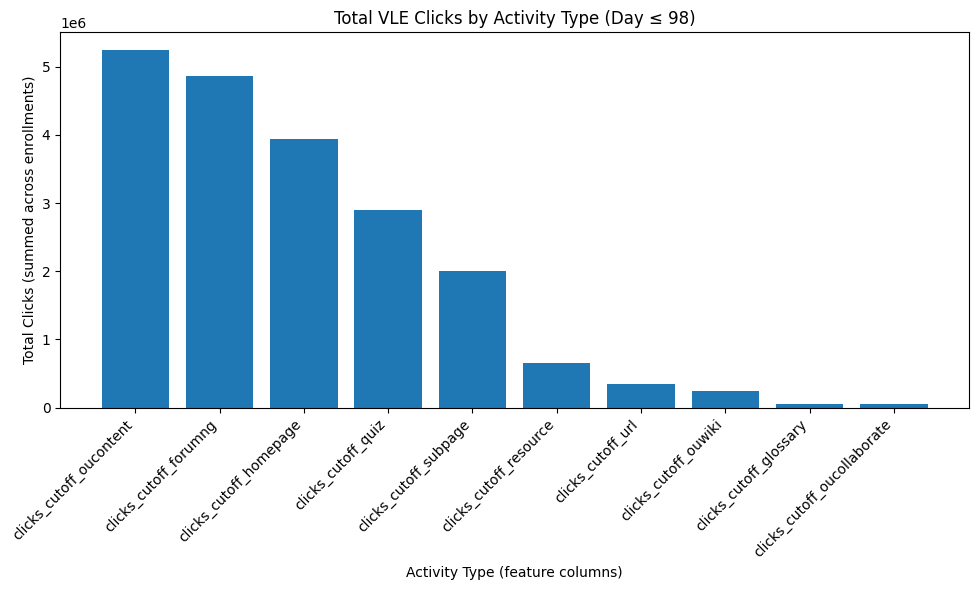

In [19]:
#

# --- Bar chart: total clicks by interaction/activity type (aggregated across all enrollments) ---  
# Identify the activity-type columns created earlier
activity_type_cols = [c for c in vle_feat.columns if c.startswith("clicks_cutoff_")]

# Sum clicks for each activity type across all student–course enrollments
activity_totals = vle_feat[activity_type_cols].sum(axis=0).sort_values(ascending=False)

# Keep only top N activity types for readability
TOP_N = 10
activity_totals_top = activity_totals.head(TOP_N)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(activity_totals_top.index, activity_totals_top.values)

ax.set_title(f"Total VLE Clicks by Activity Type (Day ≤ {CUTOFF_DAY})")
ax.set_xlabel("Activity Type (feature columns)")
ax.set_ylabel("Total Clicks (summed across enrollments)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(FIG_DIR / "visual_5_types_of_activities.png", dpi=200, bbox_inches='tight')
plt.show()

### 12. Create the Main Dataset

Construct the final modeling table by merging demographic, assessment, and VLE features into a single dataset where:
- Each row is a student–course enrolment
- Features reflect only what’s available up to the cutoff day
- Labels reflect end-of-course outcome tiers

In [20]:
# Merge demographic, assessment, and VLE features into final modeling table 
demographic_cols = [
    "code_module", "code_presentation", "id_student",
    "gender", "region", "highest_education", "imd_band", "age_band",
    "num_of_prev_attempts", "studied_credits", "disability",
    "risk_tier"
]

# Start with demographic features
keep_cols = [c for c in demographic_cols if c in base.columns]
df = base[keep_cols].copy()

# Merge in assessment and VLE features
df = df.merge(assess_feat, on=["code_module", "code_presentation", "id_student"], how="left")
df = df.merge(vle_feat, on=["code_module", "code_presentation", "id_student"], how="left")

# Fill NaN values in assessment and VLE features with 0 (indicating no activity)
print("Model table shape:", df.shape)
df.head()


Model table shape: (25353, 41)


,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,risk_tier,assessments_submitted_cutoff,avg_assessment_score_cutoff,sum_weighted_score_cutoff,latest_submit_day_cutoff,total_clicks_cutoff,interactions_cutoff,active_days_cutoff,daily_clicks_mean_cutoff,daily_clicks_std_cutoff,avg_clicks_per_active_day_cutoff,clicks_cutoff_dataplus,clicks_cutoff_dualpane,clicks_cutoff_externalquiz,clicks_cutoff_forumng,clicks_cutoff_glossary,clicks_cutoff_homepage,clicks_cutoff_htmlactivity,clicks_cutoff_oucollaborate,clicks_cutoff_oucontent,clicks_cutoff_ouelluminate,clicks_cutoff_ouwiki,clicks_cutoff_page,clicks_cutoff_questionnaire,clicks_cutoff_quiz,clicks_cutoff_repeatactivity,clicks_cutoff_resource,clicks_cutoff_sharedsubpage,clicks_cutoff_subpage,clicks_cutoff_url
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Low Risk,2.0,81.5,24.8,53.0,592.0,110.0,24.0,24.666667,32.002264,24.666667,0.0,0.0,0.0,126.0,0.0,82.0,0.0,0.0,351.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Low Risk,2.0,69.0,20.6,52.0,861.0,248.0,41.0,21.000000,22.185581,21.000000,0.0,0.0,0.0,293.0,0.0,198.0,0.0,0.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,63.0,35.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Low Risk,2.0,71.5,21.4,51.0,1057.0,317.0,56.0,18.875000,16.412925,18.875000,0.0,0.0,0.0,260.0,1.0,231.0,0.0,0.0,423.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,86.0,46.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Low Risk,2.0,49.5,12.9,75.0,722.0,201.0,37.0,19.513514,20.377850,19.513514,0.0,0.0,0.0,162.0,2.0,136.0,0.0,0.0,373.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,35.0,6.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,Low Risk,2.0,74.0,21.7,64.0,1135.0,320.0,61.0,18.606557,18.588777,18.606557,7.0,0.0,0.0,473.0,0.0,267.0,0.0,0.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,44.0,18.0


Plotting how much missing data each feature has, saves the results as a table, and creates a plot of the top most-missing features.

Goals:
- Identify features that need imputation (moderate missingness).
- Identify features might be too sparse and candidates for removal (very high missingness).

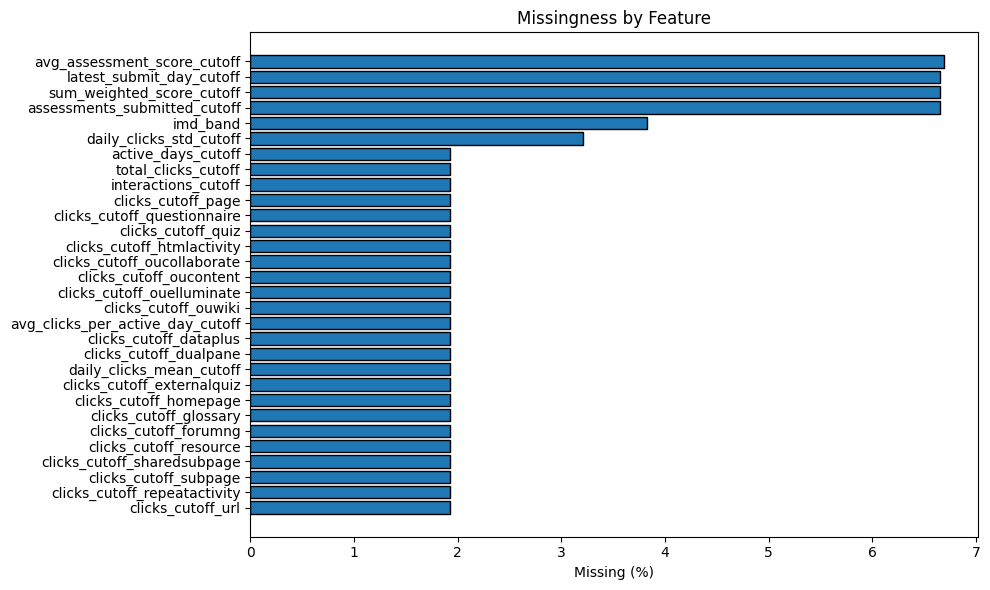

In [21]:
miss = df.isna().mean().sort_values(ascending=False) * 100
miss_df = miss.rename("missing_pct").reset_index().rename(columns={"index": "feature"})
miss_df.to_csv(TAB_DIR / "missingness_summary.csv", index=False)

fig, ax = plt.subplots(figsize=(10, 6))
top = miss_df.head(30)
ax.barh(top["feature"][::-1], top["missing_pct"][::-1], edgecolor='black', linewidth=1)
ax.set_title("Missingness by Feature")
ax.set_xlabel("Missing (%)")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_6_missingness.png", dpi=200)
plt.show()


A table of missing values for the features:

In [22]:
missing_table = (
    df.isna()
      .mean()
      .mul(100)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "feature"})
      .sort_values("missing_pct", ascending=False)
)

missing_table.to_csv(TAB_DIR / "missingness_table.csv", index=False)
missing_table.head(30)

,feature,missing_pct
13,avg_assessment_score_cutoff,6.689544
15,latest_submit_day_cutoff,6.657989
14,sum_weighted_score_cutoff,6.657989
12,assessments_submitted_cutoff,6.657989
6,imd_band,3.825977
20,daily_clicks_std_cutoff,3.214610
18,active_days_cutoff,1.924822
16,total_clicks_cutoff,1.924822
17,interactions_cutoff,1.924822
33,clicks_cutoff_page,1.924822


This missingness table highlights which variables may require imputation and which may be too sparse to rely on.

## Features Checks

### 13. Feature vs Target

A few checks to explore the relationship between key features and the target classes:

#### 13.1. Clicks in the VLE

Exploring the number of clicks (any item) in the VLE (the coruse shell).

/tmp/ipykernel_25087/2154048547.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=classes, showfliers=False)


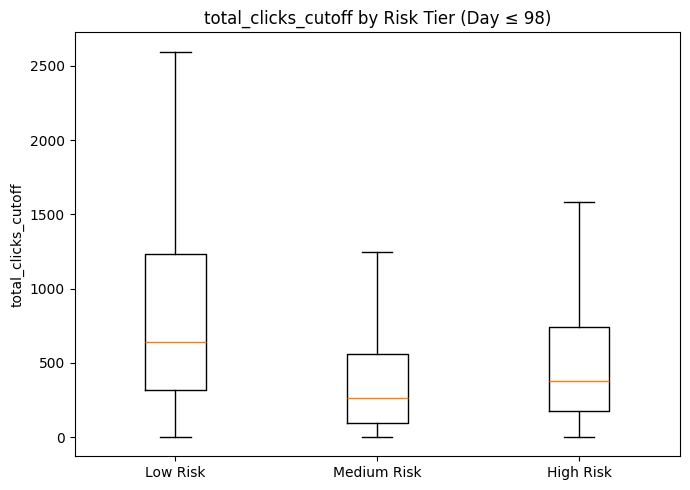

In [23]:
# Plot total_clicks_cutoff by risk_tier
feature_for_plot = "total_clicks_cutoff"
plot_df = df[[feature_for_plot, "risk_tier"]].dropna()

# Prepare data for boxplot
classes = ["Low Risk", "Medium Risk", "High Risk"]
data = [plot_df.loc[plot_df["risk_tier"] == c, feature_for_plot].values for c in classes]

# Create boxplot
fig, ax = plt.subplots(figsize=(7, 5))
ax.boxplot(data, labels=classes, showfliers=False)
ax.set_title(f"{feature_for_plot} by Risk Tier (Day ≤ {CUTOFF_DAY})")
ax.set_ylabel(feature_for_plot)
plt.xticks(rotation=0, ha="center")
plt.tight_layout()

# Save figure
plt.savefig(FIG_DIR / "visual_7_total_clicks_by_risk.png", dpi=200)

# Display the plot
plt.show()


Expected the higher-risk tiers show a lower engagement level, which support the idea that early engagement data can help predict course outcomes (final score). 

 **Insights:**
 - As expected, the Low Risk (Pass) average engagement is higher compared to Medium Risk (Fail).
 - It's interesting to note that the High Risk, have overall engagement stats that are higher than the Medium Risk.

Checking the distribution of clicks with a histogram:

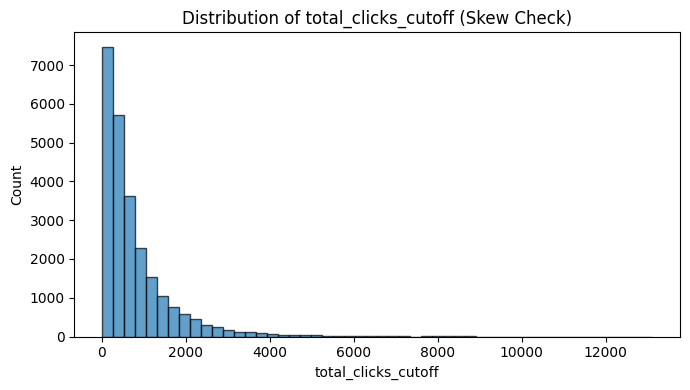

In [24]:
# Plot distribution of total_clicks_cutoff

# Prepare data
vals = df[feature_for_plot].dropna().values

# Plot histograms
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(vals, bins=50, edgecolor='black', alpha=0.7)
ax.set_title(f"Distribution of {feature_for_plot} (Skew Check)")
ax.set_xlabel(feature_for_plot)
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_8_total_clicks_distribution.png", dpi=200)
plt.show()


**Insight(s)**
The distribution is leaning left (lower values) and spans across a wide range or values with a "tail" (not inclined to think it's an error, some learners may have clicked a lot in the VLE as they were referencing materials).

Checking the distribution with a simple log transformation:<br>
Trying a simple transformation (just plotting, not altering data) to see if it helps create a more normal distribution:

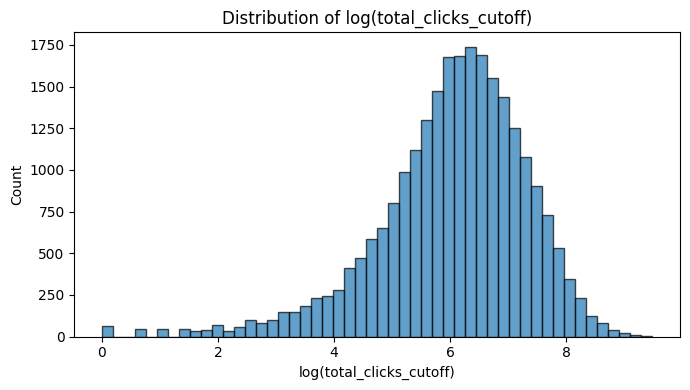

In [25]:
# Simple Log transformation plot
fig, ax = plt.subplots(figsize=(7, 4))

# Using np.log() for a simple natural log transformation
# Note: This will throw an error or return '-inf' if any values in 'vals' are 0.
ax.hist(np.log(vals), bins=50, edgecolor='black', alpha=0.7)

ax.set_title(f"Distribution of log({feature_for_plot})")
ax.set_xlabel(f"log({feature_for_plot})")
ax.set_ylabel("Count")

plt.tight_layout()

# Updated filename to reflect the change
plt.savefig(FIG_DIR / "visual_9_log_total_clicks_distribution.png", dpi=200)
plt.show()

**Insight(s):**<br>
The transformation helped with the distribution of values. This transformation could be used in the model. 


Specifcially for click rates, log1p is generally better than a simple log transformation for click rates or counts, especially when the data contains zero or very small values. Checking to see if there's a significant differecne:

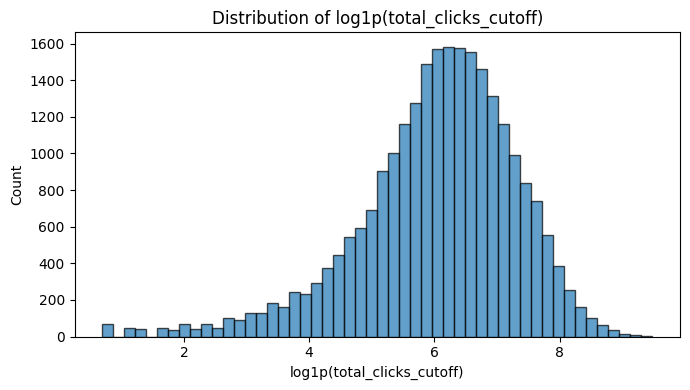

In [26]:
# Log1p transformation plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(np.log1p(vals), bins=50, edgecolor='black', alpha=0.7)
ax.set_title(f"Distribution of log1p({feature_for_plot})")
ax.set_xlabel(f"log1p({feature_for_plot})")
ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_10_log1p_total_clicks_distribution.png", dpi=200)
plt.show()


Both of the log transformation above should fit better compared to the original values of `total_clicks_cutoff`.

#### 13.2. Assessment Scores and Attempts

Exploring data about assessments in terms of score distribution and number of assessments completed within the cutoff.

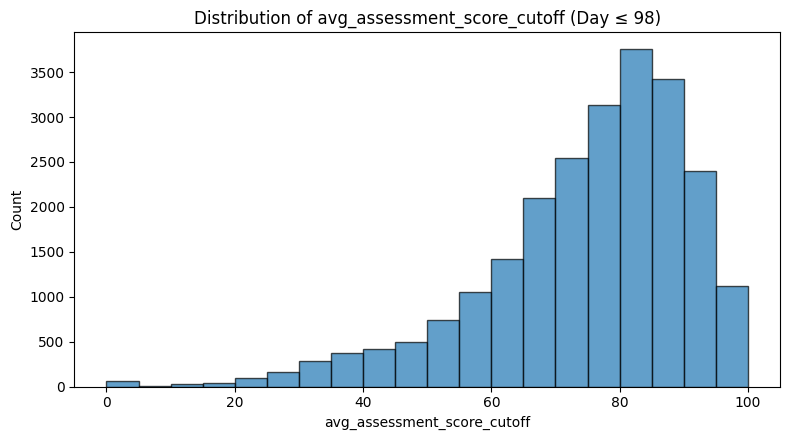

In [27]:
# Histogram of avg_assessment_score_cutoff
feature = "avg_assessment_score_cutoff"
vals = df[feature].dropna().values

if vals.size == 0:
    print(f"No values for {feature} up to cutoff.")
else:
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(vals, bins=20, edgecolor="black", alpha=0.7)
    ax.set_title(f"Distribution of {feature} (Day ≤ {CUTOFF_DAY})")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.savefig(FIG_DIR / "visual_11_avg_assessment_score_cutoff_hist.png", dpi=200, bbox_inches="tight")
    plt.show()

Checking the basic stats for average assessment scores for each category:

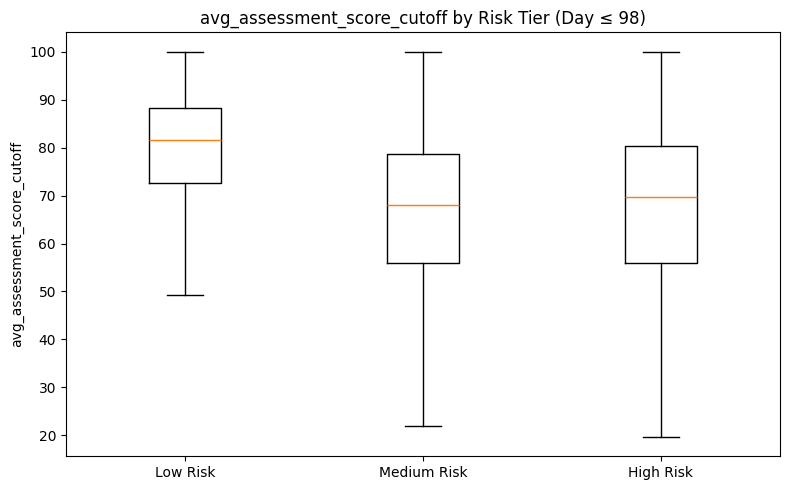

In [28]:
# Box plot: avg_assessment_score_cutoff by risk_tier
feature = "avg_assessment_score_cutoff"
plot_df = df[[feature, "risk_tier"]].dropna()
classes = ["Low Risk", "Medium Risk", "High Risk"]
data = [plot_df.loc[plot_df["risk_tier"] == c, feature].values for c in classes]

fig, ax = plt.subplots(figsize=(8, 5))

# FIX: Changed 'labels' to 'tick_labels'
ax.boxplot(data, tick_labels=classes, showfliers=False)

ax.set_title(f"{feature} by Risk Tier (Day ≤ {CUTOFF_DAY})")
ax.set_ylabel(feature)
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_12_avg_assessment_score_by_risk.png", dpi=200, bbox_inches='tight')
plt.show()

Checking the number of records for each risk tier:

In [29]:
# Counts of non-missing avg_assessment_score_cutoff by risk_tier
feature = "avg_assessment_score_cutoff"
# Subset to rows where the feature is present
non_null = df.dropna(subset=[feature])
counts = non_null['risk_tier'].value_counts().reindex(["Low Risk", "Medium Risk", "High Risk"]).fillna(0).astype(int)
print("Counts of records with non-missing values by risk_tier:")
print(counts)
print(f"Total non-missing: {counts.sum():,}")

# Also show how many are missing per tier for context
missing_by_tier = df.groupby('risk_tier')[feature].apply(lambda s: s.isna().sum()).reindex(["Low Risk", "Medium Risk", "High Risk"]).fillna(0).astype(int)
print("\nMissing counts by risk_tier:")
print(missing_by_tier)

Counts of records with non-missing values by risk_tier:
risk_tier
Low Risk       15333
Medium Risk     5716
High Risk       2608
Name: count, dtype: int64
Total non-missing: 23,657

Missing counts by risk_tier:
risk_tier
Low Risk         52
Medium Risk    1328
High Risk       316
Name: avg_assessment_score_cutoff, dtype: int64


**Insights(s):**<br>
The average score can be helpful for a separation between the "Low Risk" and the other two classes ("Medium" and "High") but it might be trivial.

- The "Low Risk" Category stands out with overall higher average score.
- The "Medium Risk" and "High Risk" are very similar in terms of the box plot. 
- Most students, when using the average score for assessment up to the cutoff are in the "Low Risk" category.

### 14. Correlation

Correlation analysis helps to any redundant numeric features:


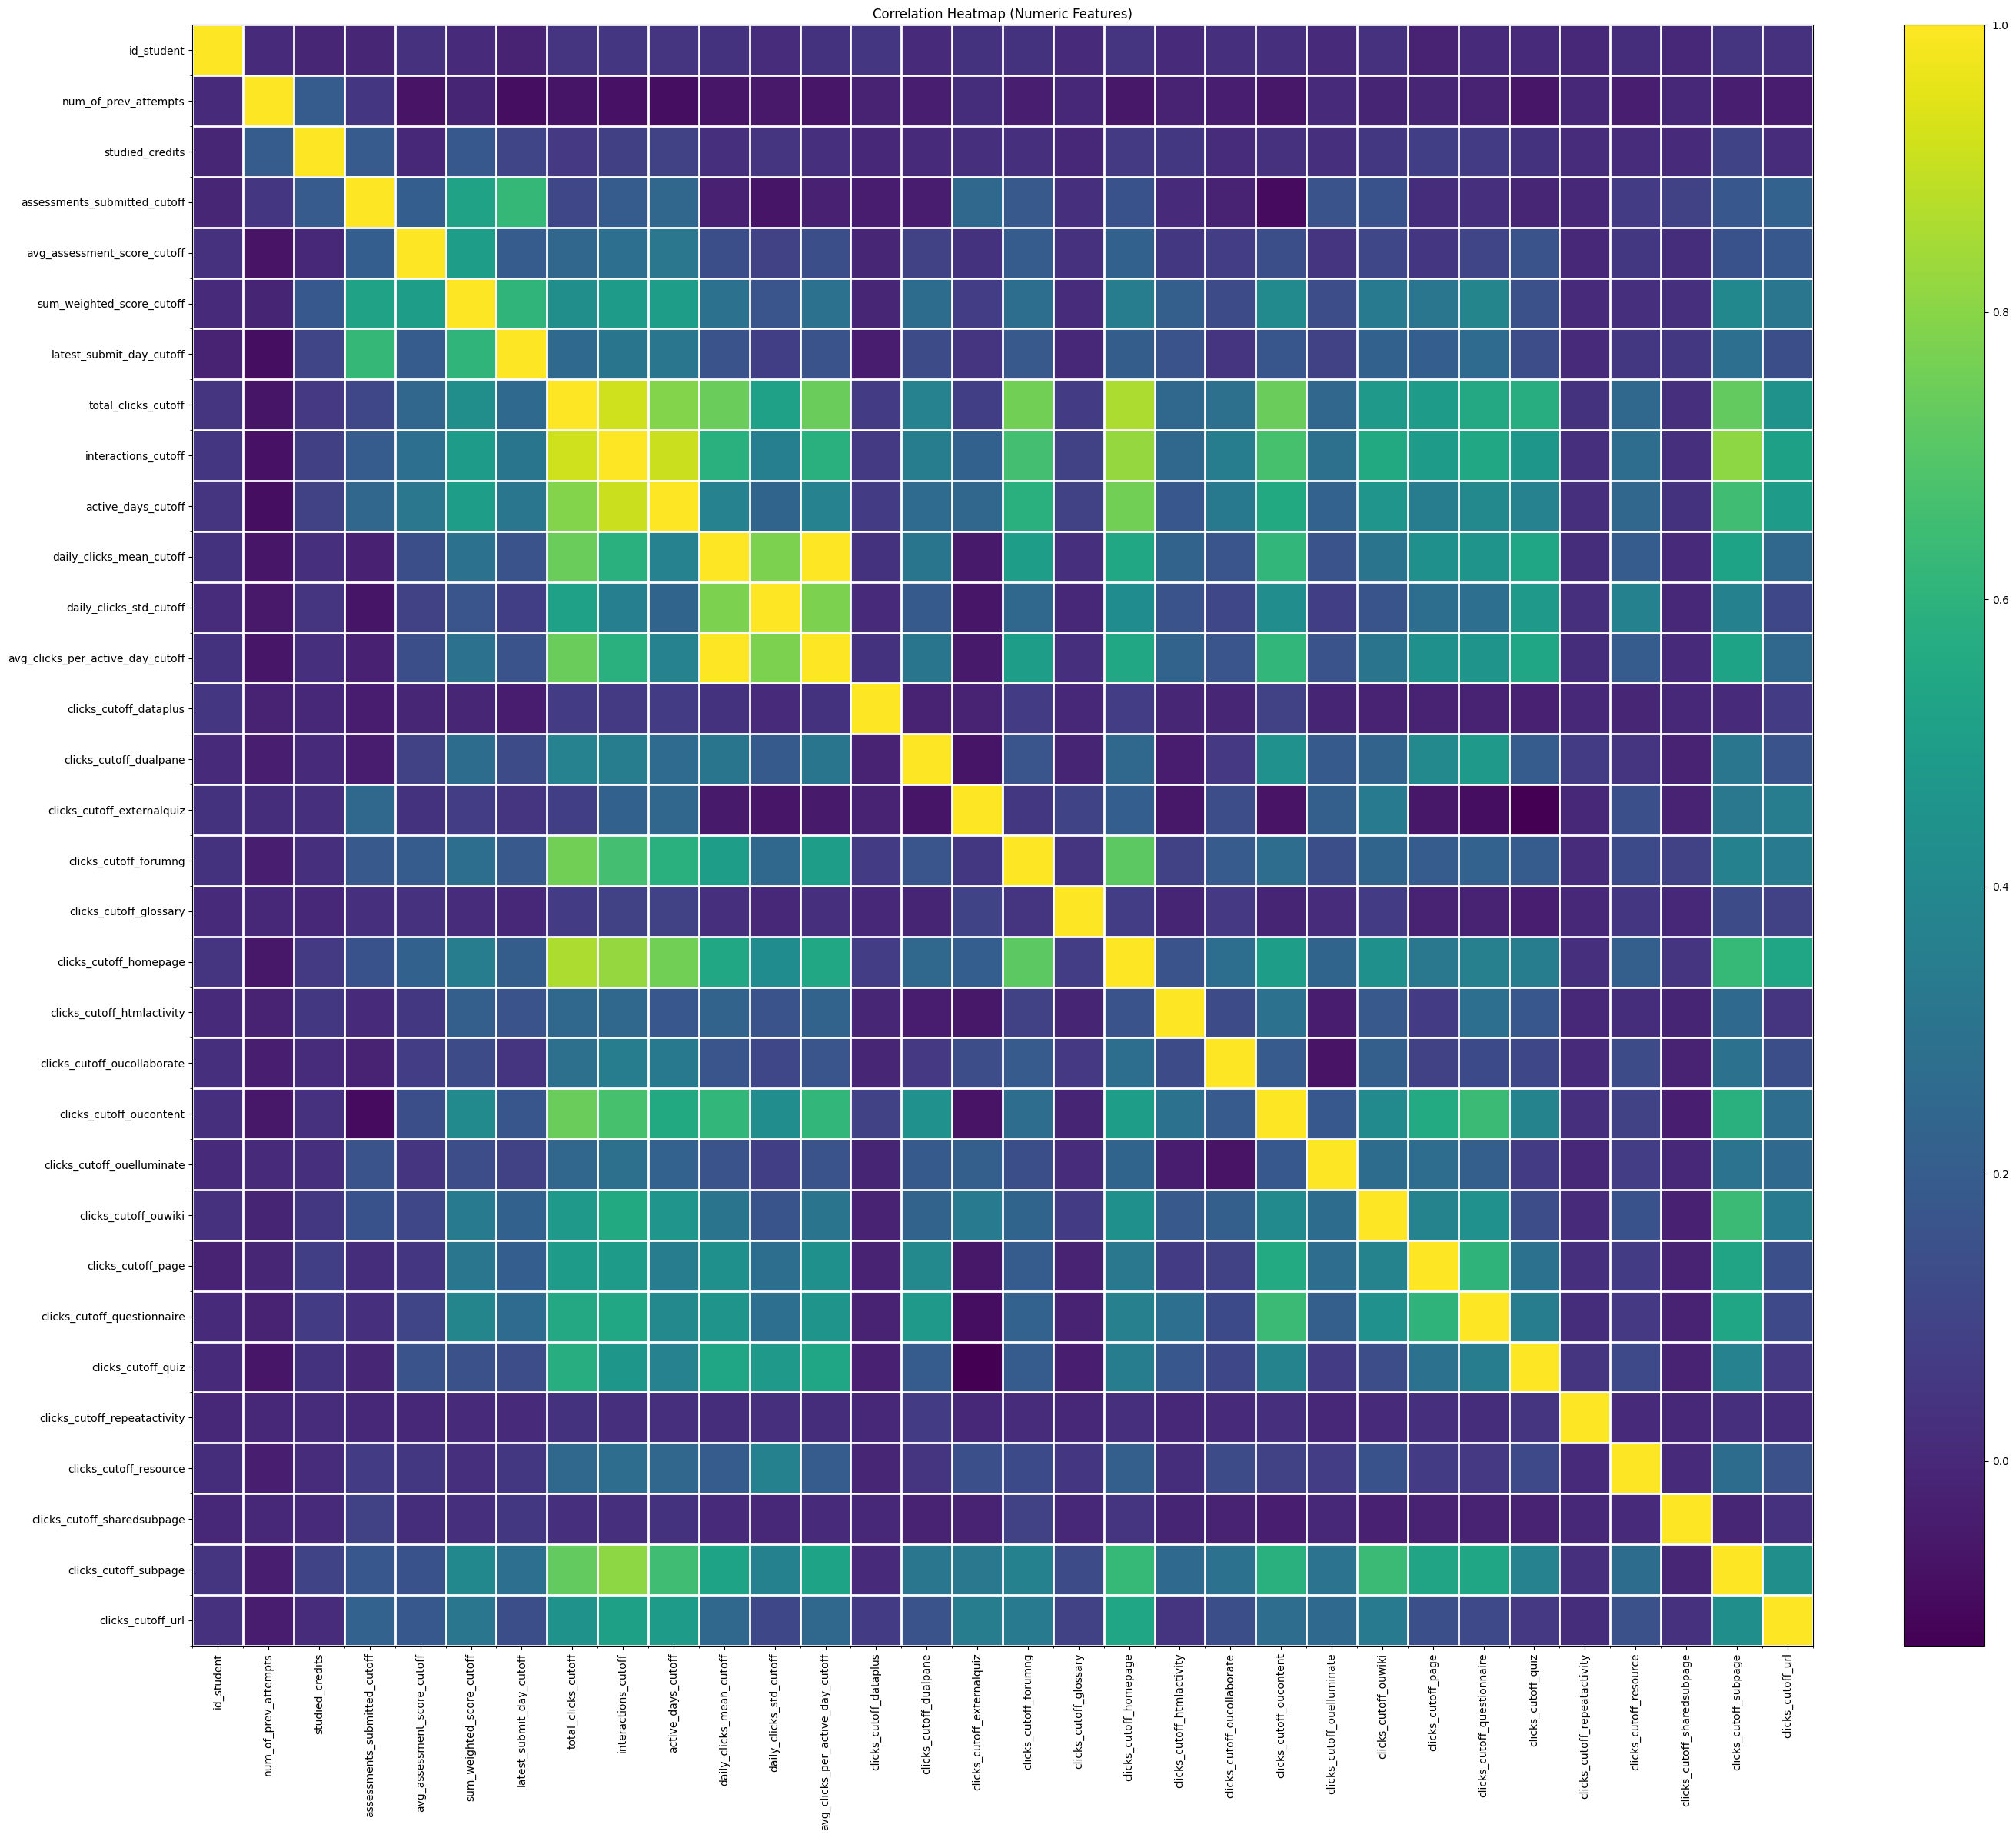

In [37]:
num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True)
corr.to_csv(TAB_DIR / "numeric_correlation_matrix.csv")

fig, ax = plt.subplots(figsize=(30, 24))
im = ax.imshow(corr.values)

# Set ticks and labels
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticks(range(len(corr.columns)))
ax.set_yticklabels(corr.columns)

# --- ADD LINES TO THE MATRIX ---
# Create minor ticks between the major ticks to draw the grid lines
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)

# Grid parameters: color, linestyle, and linewidth
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
# -------------------------------

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.savefig(FIG_DIR / "visual_13_correlation_heatmap.png", dpi=300)
plt.show()

**Insight(s):**<br>
The correlation matrix shows a few ranges that have high correlation. Given that some of those are shades of green-yellow, it merits further inspection.

In [35]:
# 1. Unstack the matrix to get pairs
# This converts the matrix into a Series with a MultiIndex (Feature 1, Feature 2)
corr_pairs = corr_matrix.unstack()

# 2. Sort by absolute value to find most significant correlations (positive or negative)
corr_table = corr_pairs.reset_index()
corr_table.columns = ['Feature 1', 'Feature 2', 'Correlation']

# 3. Filter out self-correlations (where Feature 1 == Feature 2)
corr_table = corr_table[corr_table['Feature 1'] != corr_table['Feature 2']]

# 4. Add a column for absolute correlation for better sorting
corr_table['Abs_Correlation'] = corr_table['Correlation'].abs()

# 5. Sort by the most significant values and remove duplicates (A-B is the same as B-A)
corr_table = corr_table.sort_values(by='Abs_Correlation', ascending=False)

# Remove symmetric duplicates (e.g., keep 'A'-'B' but drop 'B'-'A')
corr_table = corr_table.iloc[::2].reset_index(drop=True)

# Save to CSV and display the top 60 pairs  (started with 20, but the values were still high)
corr_table.to_csv(TAB_DIR / "sorted_correlation_pairs.csv", index=False)
print("Top 60 most significant correlation pairs:")
corr_table[['Feature 1', 'Feature 2', 'Correlation']].head(60)

Top 60 most significant correlation pairs:


,Feature 1,Feature 2,Correlation
0,avg_clicks_per_active_day_cutoff,daily_clicks_mean_cutoff,1.000000
1,total_clicks_cutoff,interactions_cutoff,0.919910
2,interactions_cutoff,active_days_cutoff,0.909321
3,clicks_cutoff_homepage,total_clicks_cutoff,0.862918
4,clicks_cutoff_homepage,interactions_cutoff,0.823598
5,interactions_cutoff,clicks_cutoff_subpage,0.807750
6,active_days_cutoff,total_clicks_cutoff,0.790609
7,daily_clicks_std_cutoff,avg_clicks_per_active_day_cutoff,0.779356
8,daily_clicks_mean_cutoff,daily_clicks_std_cutoff,0.779356
9,active_days_cutoff,clicks_cutoff_homepage,0.759560


**Insight(s):**<br>
There's a high likelyhood of redundant features:

- Most of highly-correlated features are related to the engineered features around clicks which make sense. However, they might be redundant.
- There's a correlation between the assessment related engineered features, which also makes sense since those are engineered based on the related features.

For the solution, a subset of the assessments and engagement features should be used.

## Train/Test Split

### 15. Generate Sets

Goals:
1. Get a test set
2. Get a training set
2. Group by student id to reduce identify leakage